# Filter Single-Cell Profiles
Single-cell profiles are filtered by nuclei bounding box dimensions across all plates.
Filtered is accomplished with robust z-score thresholding of nuclei bounding box dimensions obtained from cellprofiler.

In [1]:
import pathlib
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Find the root of the git repo on the host system

In [2]:
# Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

# Remove categorical warning in seaborn
warnings.filterwarnings("ignore", category=FutureWarning)

# Inputs

In [3]:
data_dir = root_dir / "nuclear_speckles_data"
nuclear_mask_dir = (data_dir / "Nuclear_masks").resolve(strict=True)
sc_profiles_path = list((data_dir / "Preprocessed_data/single_cell_profiles").resolve(strict=True).glob("*annotated*.parquet"))

# Load single-cell profile data
scdfs = [pd.read_parquet(sc_path) for sc_path in sc_profiles_path if sc_path.is_file()]

# Outputs

In [4]:
filtered_sc_path = pathlib.Path("filtered_single_cells")
filtered_sc_figure_path = filtered_sc_path / "filtered_single_cell_figures"

filtered_sc_figure_path.mkdir(parents=True, exist_ok=True)

In [5]:
def filter_bounding_box_size(_scdf, _bounding_box_col):
    """
    Filter nuclei if the robust z score of a bounding box dimension is less than three.

    Parameters
    ----------
    _scdf: Pandas Dataframe
        The unfiltered single-cell data containing bounding box dimensions.

    _bounding_box_col: String
        Column specifying the bounding box dimension.

    Returns
    -------
    Filtered single-cell pandas dataframe.
    """

    median = scdfs[_bounding_box_col].median()

    # Calculate the absolute deviations from the median
    _scdf[f"{_bounding_box_col}_absolute_deviation"] = np.abs(_scdf[_bounding_box_col] - median)

    # Calculate the MAD
    mad = _scdf[f"{_bounding_box_col}_absolute_deviation"].median()

    # Calculate the robust Z-score
    _scdf[f"{_bounding_box_col}_robust_z_score"] = (_scdf[_bounding_box_col] - median) / mad

    # Returns the single cells with a robust z score less than three
    return _scdf.loc[_scdf[f"{_bounding_box_col}_robust_z_score"] < 3]

## Retain only Common Metadata and Bounding Box Columns

In [6]:
bounding_box_cols = ["Nuclei_AreaShape_BoundingBoxMaximum_X", "Nuclei_AreaShape_BoundingBoxMinimum_X", "Nuclei_AreaShape_BoundingBoxMaximum_Y", "Nuclei_AreaShape_BoundingBoxMinimum_Y"]

common_cols = set(scdfs[0].columns[scdfs[0].columns.str.contains('Metadata')])

for scdf in scdfs[1:]:
    common_cols = set(scdf.columns[scdf.columns.str.contains('Metadata')]) & set(scdf.columns)

scdfs = pd.concat(scdfs, axis=0)[list(common_cols) + bounding_box_cols].reset_index()

## Calculate Bounding Box Dimensions

In [7]:
scdfs["Nuclei_AreaShape_BoundingBoxDelta_X"] = scdfs["Nuclei_AreaShape_BoundingBoxMaximum_X"] - scdfs["Nuclei_AreaShape_BoundingBoxMinimum_X"]
scdfs["Nuclei_AreaShape_BoundingBoxDelta_Y"] = scdfs["Nuclei_AreaShape_BoundingBoxMaximum_Y"] - scdfs["Nuclei_AreaShape_BoundingBoxMinimum_Y"]

In [8]:
scdfs.head()

,index,Metadata_Condition,Metadata_Nuclei_Site_Count,Metadata_Site,Metadata_Nuclei_Location_Center_Y,Metadata_CellLine,Metadata_Nuclei_Location_Center_X,Metadata_Plate,Metadata_ImageNumber,Metadata_Well,Nuclei_AreaShape_BoundingBoxMaximum_X,Nuclei_AreaShape_BoundingBoxMinimum_X,Nuclei_AreaShape_BoundingBoxMaximum_Y,Nuclei_AreaShape_BoundingBoxMinimum_Y,Nuclei_AreaShape_BoundingBoxDelta_X,Nuclei_AreaShape_BoundingBoxDelta_Y
0,0,NTC,40,M14,78.968641,786O,440.421603,slide3,1,A1,465.0,417.0,104.0,52.0,48.0,52.0
1,1,NTC,40,M14,104.726914,786O,419.490134,slide3,1,A1,442.0,383.0,140.0,63.0,59.0,77.0
2,2,NTC,40,M14,1150.712626,786O,228.128582,slide3,1,A1,256.0,197.0,1187.0,1123.0,59.0,64.0
3,3,NTC,40,M14,1293.612259,786O,193.636493,slide3,1,A1,214.0,165.0,1319.0,1268.0,49.0,51.0
4,4,NTC,40,M14,1344.190989,786O,238.685272,slide3,1,A1,267.0,215.0,1372.0,1316.0,52.0,56.0


# Bounding Box Dimension Distributions
Visualizes bounding box distributions before and after filtering and prints out cell counts information.

In [9]:
pre_filter_sc_count = scdfs.shape[0]
pre_scdfs = scdfs.copy()
pre_scdfs["Metadata_Filtering"] = "Removed Cells"

## Filter Nuclei by Height and Length

In [10]:
scdfs = filter_bounding_box_size(_scdf=scdfs, _bounding_box_col="Nuclei_AreaShape_BoundingBoxDelta_X")
scdfs = filter_bounding_box_size(_scdf=scdfs, _bounding_box_col="Nuclei_AreaShape_BoundingBoxDelta_Y")

scdfs.filter(like="Metadata").to_parquet(filtered_sc_path / "filtered_single_cell_profiles.parquet", index=False)
scdfs["Metadata_Filtering"] = "Retained Cells"

In [11]:
scdfs.head()

,index,Metadata_Condition,Metadata_Nuclei_Site_Count,Metadata_Site,Metadata_Nuclei_Location_Center_Y,Metadata_CellLine,Metadata_Nuclei_Location_Center_X,Metadata_Plate,Metadata_ImageNumber,Metadata_Well,...,Nuclei_AreaShape_BoundingBoxMinimum_X,Nuclei_AreaShape_BoundingBoxMaximum_Y,Nuclei_AreaShape_BoundingBoxMinimum_Y,Nuclei_AreaShape_BoundingBoxDelta_X,Nuclei_AreaShape_BoundingBoxDelta_Y,Nuclei_AreaShape_BoundingBoxDelta_X_absolute_deviation,Nuclei_AreaShape_BoundingBoxDelta_X_robust_z_score,Nuclei_AreaShape_BoundingBoxDelta_Y_absolute_deviation,Nuclei_AreaShape_BoundingBoxDelta_Y_robust_z_score,Metadata_Filtering
0,0,NTC,40,M14,78.968641,786O,440.421603,slide3,1,A1,...,417.0,104.0,52.0,48.0,52.0,2.0,0.285714,6.0,0.857143,Retained Cells
2,2,NTC,40,M14,1150.712626,786O,228.128582,slide3,1,A1,...,197.0,1187.0,1123.0,59.0,64.0,13.0,1.857143,18.0,2.571429,Retained Cells
3,3,NTC,40,M14,1293.612259,786O,193.636493,slide3,1,A1,...,165.0,1319.0,1268.0,49.0,51.0,3.0,0.428571,5.0,0.714286,Retained Cells
4,4,NTC,40,M14,1344.190989,786O,238.685272,slide3,1,A1,...,215.0,1372.0,1316.0,52.0,56.0,6.0,0.857143,10.0,1.428571,Retained Cells
5,5,NTC,40,M14,1417.101739,786O,211.043142,slide3,1,A1,...,181.0,1438.0,1397.0,59.0,41.0,13.0,1.857143,5.0,-0.714286,Retained Cells


In [12]:
print(f"\nNumber of single cells removed after filtering by bounding box size:\n{pre_filter_sc_count - scdfs.shape[0]}")


Number of single cells removed after filtering by bounding box size:
33956


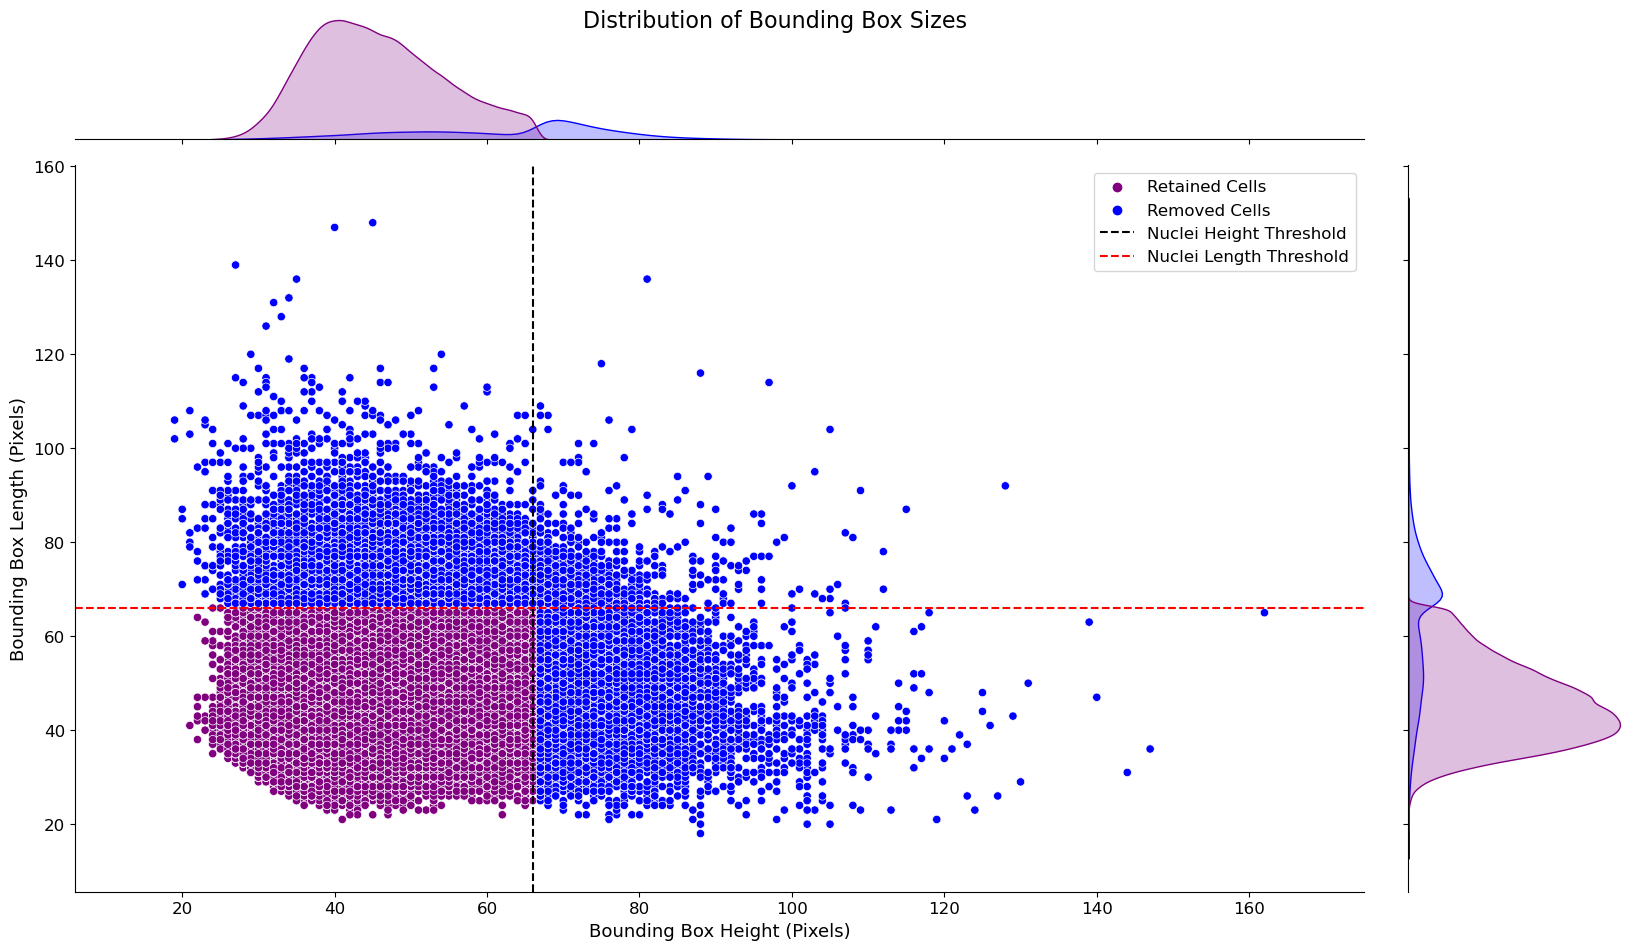

In [13]:
pre_scdfs = pre_scdfs.loc[~pre_scdfs.index.isin(scdfs.index)]

max_length = scdfs["Nuclei_AreaShape_BoundingBoxDelta_X"].max()
max_height = scdfs["Nuclei_AreaShape_BoundingBoxDelta_Y"].max()

g = sns.jointplot(data=pd.concat([scdfs, pre_scdfs], axis=0), x="Nuclei_AreaShape_BoundingBoxDelta_X", y="Nuclei_AreaShape_BoundingBoxDelta_Y", hue="Metadata_Filtering", palette={"Removed Cells": 'blue', "Retained Cells": 'purple'})
g.fig.set_size_inches(18, 10)
g.set_axis_labels("Bounding Box Height (Pixels)", "Bounding Box Length (Pixels)", fontsize=13)
g.fig.suptitle("Distribution of Bounding Box Sizes", fontsize=16)

g.ax_joint.axvline(max_height, color='black', linestyle='--', label="Nuclei Height Threshold")
g.ax_joint.axhline(max_length, color='red', linestyle='--', label='Nuclei Length Threshold')

g.ax_joint.tick_params(axis='x', labelsize=12)  # X axis tick label font size
g.ax_joint.tick_params(axis='y', labelsize=12)
g.ax_joint.legend(fontsize=12)

plt.savefig(filtered_sc_figure_path / "nuclei_dimension_distributions.png")
plt.show()